In [1]:
import pandas as pd
from shapely.geometry import Point, LineString
import numpy as np
import math

## First, tak all the trip ID from all the routes

In [2]:
routes = pd.read_csv('data/routes.txt')
calendar = pd.read_csv('data/calendar.txt')
stop_times = pd.read_csv('data/stop_times.txt')
shapes = pd.read_csv('data/shapes.txt')
trips = pd.read_csv('data/trips.txt')
calendar_dates = pd.read_csv('data/calendar_dates.txt')

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# date = 20201116
date = 20191112


# removed routes
lolland_routes = [711, 713, 714, 715, 725, 716, 717, 718, 719, 771, 772, 773, 774, 778, 780, 791, 792, 800]
lolland_routes = [str(r) for r in lolland_routes]

# movia = 221 - that is the id in transitfeed.com
movia = 221
johns800 = 321

In [4]:
bus_trips = []

for route in lolland_routes:
    route_id = routes[(routes.route_short_name == route) & ((routes.agency_id == movia) | ((routes.agency_id == johns800)))].route_id.values[0]
    print('route id = ', route_id, 'route name = ', route)
    all_trips = trips[trips.route_id == route_id].set_index('service_id').join(calendar.set_index('service_id')).reset_index()
    bus_trips.append({'route': route, 'trips': all_trips.trip_id.values})
    print(','.join(str(s) for s in all_trips.trip_id.values))
    print()

route id =  20529_3 route name =  711
65425925,65425924,65425923,65425922,65425921,65425920,65425919,65425926,65425918,65425887,65425886,65425885,65425884,65425909,65425908,65425907,65425906,65425905,65425904,65425903,65425902,65425901,65425900,65425899,65425917,65425915,65425913,65425911,65425916,65425914,65425912,65425910,65425898,65425897,65425896,65425895,65425894,65425893,65425892,65425891,65425889,65425888,65425890

route id =  20531_3 route name =  713
65425936,65425935,65425934,65425933,65425932,65425931,65425930,65425929,65425928,65425927

route id =  21268_3 route name =  714
65425946,65425945,65425944,65425943,65425942,65425941,65425940,65425939,65425938,65425937

route id =  21269_3 route name =  715
65425972,65425971,65425960,65425969,65425966,65425968,65425965,65425962,65425964,65425961,65425963,65425967,65425970,65425953,65425948,65425955,65425956,65425950,65425951,65425949,65425947,65425959,65425957,65425958,65425952,65425954

route id =  20539_3 route name =  725
65426

In [5]:
bus_trips

[{'route': '711',
  'trips': array([65425925, 65425924, 65425923, 65425922, 65425921, 65425920,
         65425919, 65425926, 65425918, 65425887, 65425886, 65425885,
         65425884, 65425909, 65425908, 65425907, 65425906, 65425905,
         65425904, 65425903, 65425902, 65425901, 65425900, 65425899,
         65425917, 65425915, 65425913, 65425911, 65425916, 65425914,
         65425912, 65425910, 65425898, 65425897, 65425896, 65425895,
         65425894, 65425893, 65425892, 65425891, 65425889, 65425888,
         65425890])},
 {'route': '713',
  'trips': array([65425936, 65425935, 65425934, 65425933, 65425932, 65425931,
         65425930, 65425929, 65425928, 65425927])},
 {'route': '714',
  'trips': array([65425946, 65425945, 65425944, 65425943, 65425942, 65425941,
         65425940, 65425939, 65425938, 65425937])},
 {'route': '715',
  'trips': array([65425972, 65425971, 65425960, 65425969, 65425966, 65425968,
         65425965, 65425962, 65425964, 65425961, 65425963, 65425967,
       

In [6]:
bus_trips_all_ids = [trip for route in bus_trips for trip in route['trips']]

In [7]:
len(bus_trips_all_ids)

326

## Processing trip dump

In [8]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
pd.set_option('display.max_rows', None)
import zipfile
import os
import shutil
import json

In [9]:
scenario_name = "local_test"
path_to_zip_file = '/home/ai6644/Malmo/Tools/Simulation results/Lolland/tw around departure, stretched, with transfers/'+\
                   scenario_name+'/log.zip'

In [10]:
day_sec = int(86400)
day_h = int(24)

In [11]:
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    try:
        shutil.rmtree('data/zip')
    except (FileNotFoundError, OSError) as e:
        pass
    os.mkdir('data/zip')
    zip_ref.extractall('data/zip')
path = 'data/zip/' + os.listdir('data/zip')[0] + '/trip_dump.json'

In [12]:
all_files = glob.glob("data/zip/*/vehicle_logs/vehicle_occupancy_*")
n_cars = len(all_files)

In [13]:
fp = open(path)
tdump = json.load(fp)
fp.close()
persons = tdump.get('person')

In [14]:
trip_ids = {}
counter_legs = 0
no_trips = 0
counter_trips = 0
for person in persons:
    try:
        act_trip = person['actual_trips'][0]
    except IndexError:
        no_trips += 1
        continue
    if act_trip['main_mode'] == 'CAR':
        continue
        
    counter_trips += 1
    
    for leg in act_trip['legs']:
        if leg['trip_id'] not in bus_trips_all_ids:
            continue

        
        if leg['trip_id'] not in trip_ids.keys():
            trip_ids[leg['trip_id']] = []

        trip_ids[leg['trip_id']].append({'start_time': leg['start_time'], 'end_time': leg['end_time']})
        counter_legs += 1
print('legs', counter_legs)
print('trips', counter_trips)
print('excluded', no_trips)

legs 16
trips 33
excluded 0


In [15]:
counter = 0
ids = []
routes = []
for person in persons:
    try:
        act_trip = person['actual_trips'][0]
    except IndexError:
        continue
    
    if act_trip['main_mode'] == 'TRANSIT,WALK':
        for leg in act_trip['legs']:
            if leg['mode'] == 'BUS':
                ids.append(leg['trip_id'])
                routes.append(leg['route'])
                counter += 1
    
print(counter)

19


In [16]:
set(routes)

{'401A', '711', '714', '715', '717', '718', '719', '720R', '725'}

In [17]:
trip_ids

{65426015: [{'start_time': 22590.0, 'end_time': 24060.0}],
 65425926: [{'start_time': 24600.0, 'end_time': 24840.0}],
 65425953: [{'start_time': 22410.0, 'end_time': 23700.0}],
 65426036: [{'start_time': 29100.0, 'end_time': 31260.0},
  {'start_time': 30240.0, 'end_time': 31260.0}],
 65426003: [{'start_time': 29400.0, 'end_time': 30060.0}],
 65425945: [{'start_time': 32040.0, 'end_time': 32220.0}],
 65426041: [{'start_time': 38940.0, 'end_time': 39960.0}],
 65426063: [{'start_time': 44040.0, 'end_time': 45120.0}],
 65425941: [{'start_time': 46260.0, 'end_time': 46440.0}],
 65426054: [{'start_time': 53340.0, 'end_time': 54480.0}],
 65425958: [{'start_time': 52200.0, 'end_time': 52500.0}],
 65425962: [{'start_time': 56640.0, 'end_time': 58140.0}],
 65426379: [{'start_time': 57120.0, 'end_time': 59160.0}],
 65426068: [{'start_time': 62040.0, 'end_time': 63120.0}],
 65425918: [{'start_time': 62460.0, 'end_time': 62820.0}]}

In [18]:
df = pd.DataFrame(index=range(0,86400))

In [19]:
for bus_trip in bus_trips:
    print(bus_trip['route'])
    for trip in bus_trip['trips']:
        df[trip] = np.zeros(86400)
        try:
            for pers in trip_ids[trip]:
                df.loc[int(pers['start_time']):int(pers['end_time']),trip] += np.zeros(int(pers['end_time']) - int(pers['start_time']) + 1)+1
        except KeyError:
            print('no trips in ', trip)
        

711
no trips in  65425925
no trips in  65425924
no trips in  65425923
no trips in  65425922
no trips in  65425921
no trips in  65425920
no trips in  65425919
no trips in  65425887
no trips in  65425886
no trips in  65425885
no trips in  65425884
no trips in  65425909
no trips in  65425908
no trips in  65425907
no trips in  65425906
no trips in  65425905
no trips in  65425904
no trips in  65425903
no trips in  65425902
no trips in  65425901
no trips in  65425900
no trips in  65425899
no trips in  65425917
no trips in  65425915
no trips in  65425913
no trips in  65425911
no trips in  65425916
no trips in  65425914
no trips in  65425912
no trips in  65425910
no trips in  65425898
no trips in  65425897
no trips in  65425896
no trips in  65425895
no trips in  65425894
no trips in  65425893
no trips in  65425892
no trips in  65425891
no trips in  65425889
no trips in  65425888
no trips in  65425890
713
no trips in  65425936
no trips in  65425935
no trips in  65425934
no trips in  65425933
no

In [20]:
df[59739071].value_counts()

0.0    86400
Name: 59739071, dtype: int64

In [21]:
df.head()

,65425925,65425924,65425923,65425922,65425921,65425920,65425919,65425926,65425918,65425887,...,65427340,65427339,65427345,65427344,65427343,65427342,59739069,59739071,59739070,59739072
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df[65425925].value_counts()

0.0    86400
Name: 65425925, dtype: int64

In [23]:
stop_times[stop_times['trip_id'] == 64845553].sort_values('stop_sequence')

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,stop_headsign
0,64845553,8:10:00,8:10:00,407000101,0,0,0,Gudhjem via Hasle/Allinge
1,64845553,8:11:00,8:11:00,407000401,1,0,0,Gudhjem via Hasle/Allinge
2,64845553,8:13:00,8:13:00,407000201,2,0,0,Gudhjem via Hasle/Allinge
3,64845553,8:15:00,8:15:00,407020001,3,0,0,Gudhjem via Hasle/Allinge
4,64845553,8:16:00,8:16:00,407002801,4,0,0,Gudhjem via Hasle/Allinge
5,64845553,8:17:00,8:17:00,407003001,5,0,0,Gudhjem via Hasle/Allinge
6,64845553,8:18:00,8:18:00,407010901,6,0,0,Gudhjem via Hasle/Allinge
7,64845553,8:19:00,8:19:00,407010501,7,0,0,Gudhjem via Hasle/Allinge
8,64845553,8:20:00,8:20:00,407002101,8,0,0,Gudhjem via Hasle/Allinge
9,64845553,8:21:00,8:21:00,407106001,9,0,0,Gudhjem via Hasle/Allinge


In [24]:
df[df.columns[0]].value_counts()

0.0    86400
Name: 65425925, dtype: int64

In [25]:
for tripid in df.columns:
    stops = stop_times[stop_times['trip_id'] == tripid].sort_values('stop_sequence')
    start = sum([h*s for h,s in zip([int(x) for x in stops.iloc[0]['departure_time'].split(':')], [60*60, 60, 1])])
    end   = sum([h*s for h,s in zip([int(x) for x in stops.iloc[-1]['arrival_time'].split(':')], [60*60, 60, 1])])
    df.loc[0:start-1, tripid] = -3
    df.loc[end+1:, tripid] = -3

In [26]:
df[df.columns[0]].value_counts()

-3.0    84959
 0.0     1441
Name: 65425925, dtype: int64

(array([311.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,  14.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.]),
 array([0.        , 0.05714286, 0.11428571, 0.17142857, 0.22857143,
        0.28571429, 0.34285714, 0.4       , 0.45714286, 0.51428571,
        0.57142857, 0.62857143, 0.68571429, 0.74285714, 0.8       ,
        0.85714286, 0.91428571, 0.97142857, 1.02857143, 1.08571429,
        1.14285714, 1.2       , 1.25714286, 1.31428571, 1.37142857,
        1.42857143, 1.48571429, 1.54285714, 1.6       , 1.65714286,
        1.71428571, 1.77142857, 1.82857143, 1.88571429, 1.94285714,
        2.        ]),
 <a list of 35 Patch objects>)

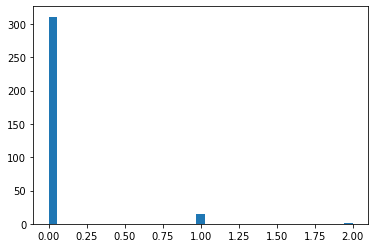

In [27]:
a = df.describe().loc['max'].values
fig = plt.figure()
ax = plt.subplot(111)

plt.hist(a, 35)

In [28]:
df.head()

,65425925,65425924,65425923,65425922,65425921,65425920,65425919,65425926,65425918,65425887,...,65427340,65427339,65427345,65427344,65427343,65427342,59739069,59739071,59739070,59739072
0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
1,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
2,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
3,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
4,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0


In [29]:
df[59739071].value_counts()

-3.0    73379
 0.0    13021
Name: 59739071, dtype: int64

## Now compute occupancy by time

In [30]:
# The subset of lines we are interested in
filtered_routes = [711, 713, 714, 715, 718, 719, 771, 772, 773, 774, 778, 791, 792]
filtered_routes = [str(x) for x in filtered_routes]
filtered_trips = []
for bus_trip in bus_trips:
    if bus_trip['route'] in filtered_routes:
#         print(bus_trip['route'])
        filtered_trips.extend(bus_trip['trips'])

df2 = df[filtered_trips]
df2.head()

,65425925,65425924,65425923,65425922,65425921,65425920,65425919,65425926,65425918,65425887,...,65427109,65427108,65427338,65427341,65427340,65427339,65427345,65427344,65427343,65427342
0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
1,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
2,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
3,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
4,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0


In [31]:
li=[]
for i in range(0, len(df)):
    li.append(df.iloc[i].value_counts())
#     li[-1].index = 8 - li[-1].index.values

In [32]:
day_values = pd.concat(li, axis=1).fillna(0).T.reindex(index=[_ for _ in range(0, day_sec)]).fillna(method='ffill')

In [33]:
day_values.head()

,-3.0,0.0,1.0,2.0
0,326.0,0.0,0.0,0.0
1,326.0,0.0,0.0,0.0
2,326.0,0.0,0.0,0.0
3,326.0,0.0,0.0,0.0
4,326.0,0.0,0.0,0.0


In [34]:
day_values.describe()

,-3.0,0.0,1.0,2.0
count,86400.000000,86400.000000,86400.000000,86400.000000
mean,317.027477,8.802211,0.158495,0.011817
std,8.229886,8.080558,0.454298,0.108063
min,297.000000,0.000000,0.000000,0.000000
25%,311.000000,0.000000,0.000000,0.000000
50%,316.000000,10.000000,0.000000,0.000000
75%,326.000000,15.000000,0.000000,0.000000
max,326.000000,27.000000,2.000000,1.000000


In [35]:
day_values2 = pd.DataFrame(df[65426065])

In [36]:
day_values2 = day_values

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


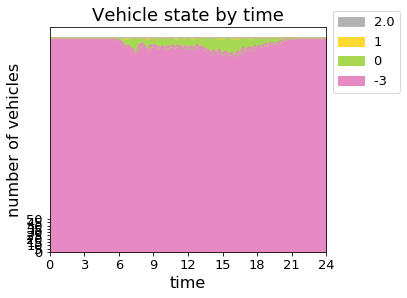

In [37]:
from matplotlib import cm
import matplotlib.patches as mpatches
# color_list = [i for i in cm.get_cmap("Set2").colors]*2
color_list = [i for i in [c for c in cm.get_cmap("Set2").colors[:-2]] + [cm.get_cmap("Set2").colors[-1]]]*4

fig = plt.figure()
ax = fig.add_axes([0.12, 0.13, 0.64, 0.78])
ax.set_ylabel('number of vehicles', {'fontsize': 16})
ax.set_xlabel('time', {'fontsize': 16})
ax.set_title('Vehicle state by time', {'fontsize': 18})
# day_values2.plot.area(stacked=True, ax=ax, linewidth=1)
day_values2.plot.area(stacked=True, ax=ax, linewidth=1, color=color_list[len(color_list)-len(day_values2.columns):])
labels = [day_values2.columns.to_list()[::-1][0]] + [str(int(l))+' ' for l in day_values2.columns.to_list()[::-1][1:]]
leg = [mpatches.Patch(color=c, label=l) for l,c in zip(labels,color_list[len(color_list)-len(day_values2.columns):][::-1])]
plt.legend(handles=leg, bbox_to_anchor=(1, 1.1), fontsize=13)
plt.xticks(np.linspace(0, day_sec, 9), np.linspace(0, day_h, 9, dtype='int'), fontsize=13)
plt.yticks(np.linspace(0, 50, 11), np.linspace(0, 50, 11, dtype='int'), fontsize=13)
# plt.ylim(0,n_cars)
# plt.xlim(4*60*60,day_sec)
# plt.gcf().subplots_adjust(right=0.8)
plt.savefig('data/occupancy.png', dpi=600)

In [38]:
occ_by_time = {i:0 for i in range(-3, 40+1)}
for i,j in zip(day_values.iterrows(), day_values.iloc[1:].iterrows()):
    for el in i[1].index.values:
        occ_by_time[el] += (j[0] - i[0]) * j[1][el]

(0, 400000)

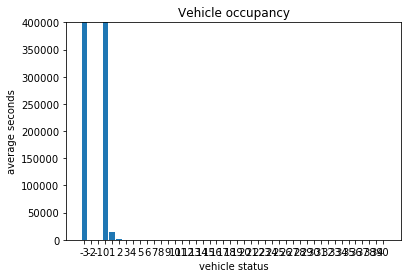

In [39]:
fig = plt.figure()
ax = plt.subplot(111)

plt.bar([str(i) for i in range(-3,40+1)], [i for i in list(occ_by_time.values())])
ax.set_ylabel('average seconds')
ax.set_xlabel('vehicle status')
ax.set_title('Vehicle occupancy')
plt.ylim(0, 40000*10)